In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from functools import wraps
from sklearn.metrics import ndcg_score
from glob import glob
import shap
from os import path as osp
import japanize_matplotlib

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
BASE_DIR = 'data/'
USE_RACE_COL = ['着順', '馬名', '性齢', '斤量', '騎手', 'タイム', '着差', '単勝', '人気', '馬体重', '調教師', 'horse_id', 'jockey_id']

In [8]:
p_race_csvs = sorted(glob(osp.join(BASE_DIR, 'race_results*.csv')))
p_race_csvs

['data\\race_results_202401010101.csv',
 'data\\race_results_202401010102.csv',
 'data\\race_results_202401010103.csv',
 'data\\race_results_202401010104.csv',
 'data\\race_results_202401010105.csv',
 'data\\race_results_202401010106.csv',
 'data\\race_results_202401010107.csv',
 'data\\race_results_202401010108.csv',
 'data\\race_results_202401010109.csv',
 'data\\race_results_202401010110.csv',
 'data\\race_results_202401010111.csv',
 'data\\race_results_202401010112.csv',
 'data\\race_results_202401010201.csv',
 'data\\race_results_202401010202.csv',
 'data\\race_results_202401010203.csv',
 'data\\race_results_202401010204.csv',
 'data\\race_results_202401010205.csv',
 'data\\race_results_202401010206.csv',
 'data\\race_results_202401010207.csv',
 'data\\race_results_202401010208.csv',
 'data\\race_results_202401010209.csv',
 'data\\race_results_202401010210.csv',
 'data\\race_results_202401010211.csv',
 'data\\race_results_202401010212.csv',
 'data\\race_results_202401010301.csv',


In [9]:
def save_dfs_to_excel(file_path, dfs_dict):
    """
    複数のDataFrameを指定されたExcelファイルのシートに保存する関数。

    Parameters:
    - file_path: str
        保存先のExcelファイルパス
    - dfs_dict: dict
        シート名をキー、DataFrameを値とする辞書

    Returns:
    - None
    """
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        for sheet_name, df in dfs_dict.items():
            if isinstance(df, pd.DataFrame):
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            else:
                raise ValueError(f"キー '{sheet_name}' に対応する値がDataFrameではありません。")
    print(f"DataFramesが正常に {file_path} に保存されました。")

In [10]:
def load_processed_df(p_csv, USE_RACE_COL=USE_RACE_COL):
    df = pd.read_csv(p_csv)
    df.columns = [c.replace(' ', '') for c in df.columns]
    df = df[USE_RACE_COL]
    df["レースID"] = int(osp.basename(p_csv).split('_')[2].split('.')[0])  # 各DataFrameにレースIDを付与
    df['牝'] = df['性齢'].map(lambda x: x[0] == '牝')  # 性別を表す列を追加
    df['齢'] = df['性齢'].map(lambda x: int(x[1:]))
    df['馬体重'] = df['馬体重'].map(lambda s: s if s != '計不' else None)
    df['当日体重'] = df['馬体重'].map(lambda s: int(s.split('(')[0]) if s is not None else None)
    df['増減'] = df['馬体重'].map(lambda s: int(s.split('(')[1].replace(')', '')) if s is not None else None)
    df.loc[df['着順'] == 1, '着差'] = 0
    df = df.drop(['性齢', '馬体重'], axis=1)
    df = df.loc[~df['着順'].isin(['取', '中', '除', '失'])]
    df = df.rename(columns={'jockey_id': '騎手ID', 'horse_id': '馬ID'})
    df['着順'] = (1 + len(df) - df['着順'].astype(int))
    return df

In [11]:
# 複数のDataFrameをリストとして保持
dfs = [load_processed_df(p_race_csv) for p_race_csv in p_race_csvs]

# 単一のデータフレームに統合
merged_df = pd.concat(dfs, ignore_index=True)

merged_df

,着順,馬名,斤量,騎手,タイム,着差,単勝,人気,調教師,馬ID,騎手ID,レースID,牝,齢,当日体重,増減
0,5,ポッドベイダー,55.0,佐々木大,1:08.8,0,1.2,1.0,[東] 上原佑紀,2022105244,1197,202401010101,False,2,462.0,-2.0
1,4,ニシノクードクール,55.0,武藤雅,1:09.1,1.3/4,10.2,4.0,[東] 武藤善則,2022106999,1169,202401010101,True,2,452.0,-2.0
2,3,ロードヴェルト,55.0,横山武史,1:09.4,1.3/4,7.9,3.0,[西] 牧浦充徳,2022100639,1170,202401010101,False,2,416.0,6.0
3,2,ルージュアマリア,55.0,永野猛蔵,1:10.0,3.1/2,5.9,2.0,[東] 黒岩陽一,2022105762,1188,202401010101,True,2,410.0,6.0
4,1,ロードヴァルカン,54.0,角田大河,1:10.1,クビ,21.3,5.0,[西] 中村直也,2022100660,1199,202401010101,False,2,438.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45134,5,グランデスフィーダ,58.0,荻野極,1:46.6,2,32.3,9.0,[西] 池江泰寿,2020104913,1160,202410030812,False,4,528.0,-2.0
45135,4,アメリカンチーフ,54.0,西塚洸二,1:46.8,1.1/4,51.0,11.0,[西] 音無秀孝,2021110123,1200,202410030812,False,3,464.0,0.0
45136,3,シブースト,53.0,吉村誠之,1:49.0,大,167.0,15.0,[西] 高野友和,2020100160,1216,202410030812,True,4,502.0,-2.0
45137,2,ペイシャコパ,50.0,河原田菜,1:49.1,3/4,85.7,14.0,[西] 坂口智康,2021101090,1204,202410030812,True,3,456.0,0.0


In [12]:
# レースIDを取得
race_ids = merged_df["レースID"].unique()
train_valid_ids, test_ids = train_test_split(race_ids, test_size=0.2, shuffle=False)
train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.2, shuffle=False)
print(f'train size: {len(train_ids)}, valid size: {len(valid_ids)}, test size: {len(test_ids)}')

# トレーニングデータとテストデータに分割
train_df = merged_df[merged_df["レースID"].isin(train_ids)]
valid_df = merged_df[merged_df["レースID"].isin(valid_ids)]
test_df = merged_df[merged_df["レースID"].isin(test_ids)]

# グループ情報の再計算
train_group = train_df.groupby("レースID").size().tolist()
valid_group = valid_df.groupby("レースID").size().tolist()
test_group = test_df.groupby("レースID").size().tolist()

# 特徴量とターゲットの抽出
features = ["斤量", "馬ID", "騎手ID", "牝", "齢", "人気", "当日体重", "増減"]

X_train = train_df[features]
X_valid = valid_df[features]
X_test = test_df[features]
y_train = train_df["着順"]
y_valid = valid_df["着順"]
y_test = test_df["着順"]

train size: 2131, valid size: 533, test size: 667


In [13]:
# LightGBM データセットの作成
train_data = lgb.Dataset(X_train, label=y_train, group=train_group)
valid_data = lgb.Dataset(X_valid, label=y_valid, group=valid_group, reference=train_data)
test_data = lgb.Dataset(X_test, label=y_test, group=test_group, reference=train_data)

# モデルのハイパーパラメータ設定
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "boosting": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "verbose": -1
}

# モデルの学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=1000,
)

In [14]:
# テストデータでの予測
y_pred = model.predict(X_test)

# NDCGスコアの計算
true_relevance = [list(y_test)]
predicted_scores = [y_pred]
ndcg = ndcg_score(true_relevance, predicted_scores)
print(f"NDCGスコア: {ndcg}")

NDCGスコア: 0.9472200855552154


In [15]:
result_dir = 'outputs/'
result_dfs = dict()
test_df.loc[:, '予測重み'] = y_pred
race_ids = test_df.loc[:, 'レースID'].unique()
for race_id in race_ids:
    result_df = test_df.loc[test_df['レースID'] == race_id, :].copy()
    result_df.loc[:, '予測'] = result_df.loc[:, '予測重み'].rank(ascending=False, method='min')
    test_df.loc[result_df.index, '予測'] = result_df.loc[:, '予測']
    result_df.loc[:, '着順'] = 1 + len(result_df) - result_df.loc[:, '着順']
    result_df = result_df.loc[:, ['レースID', '予測', '着順', '馬名', '人気']].sort_values('予測', ascending=True)
    result_df = result_df.reset_index(drop=True)
    result_dfs[str(result_df['レースID'].values[0])] = result_df
    print(result_df)
    print('---')

           レースID    予測  着順         馬名    人気
0   202408050101   1.0   1   テーオーエルビス   1.0
1   202408050101   2.0   2  セントールビースト   2.0
2   202408050101   3.0   3   テイエムダイタカ   3.0
3   202408050101   4.0   4     ソイジャガー   5.0
4   202408050101   5.0   9  メイショウマサツラ   4.0
5   202408050101   6.0   5    ストームレーン   6.0
6   202408050101   7.0   7   スナークサンダー   7.0
7   202408050101   8.0  10  テイエムパイロット  10.0
8   202408050101   9.0   6   ゴッドペイズリー   9.0
9   202408050101  10.0   8    ドラマツルギー   8.0
10  202408050101  11.0  11   ブラックデザイア  12.0
11  202408050101  12.0  12   リケアマキアート  11.0
---
          レースID   予測  着順         馬名    人気
0  202408050102  1.0   2  アートレスマインド   3.0
1  202408050102  2.0   3      メレサンク   1.0
2  202408050102  3.0   5   カガセブンスター   2.0
3  202408050102  4.0   1     シュラザック   4.0
4  202408050102  5.0   9   ランワールドワン  10.0
5  202408050102  6.0   6  プリスクリプション   9.0
6  202408050102  7.0   4     バルミラクル   6.0
7  202408050102  8.0   8   ノーザトゥルース   7.0
8  202408050102  9.0   7  シャドーストライク   8.0
---


In [16]:
save_dfs_to_excel('outputs/baseline_prediction.xlsx', result_dfs)

DataFramesが正常に outputs/baseline_prediction.xlsx に保存されました。


In [17]:
def calc_mean_rank(test_df, race_id):
    test_df = test_df.copy()
    sub_df = test_df.loc[test_df.loc[:, 'レースID'] == race_id, :]
    sub_df = sub_df.sort_values('予測', ascending=False).reset_index()
    return sub_df.loc[sub_df['着順'] == 1].index.tolist()[0] + 1

mean_rank = np.nanmean([calc_mean_rank(test_df, race_id) for race_id in test_df.loc[:, 'レースID'].unique()])
print(f'平均順位誤差: {mean_rank}')

平均順位誤差: 4.580209895052474


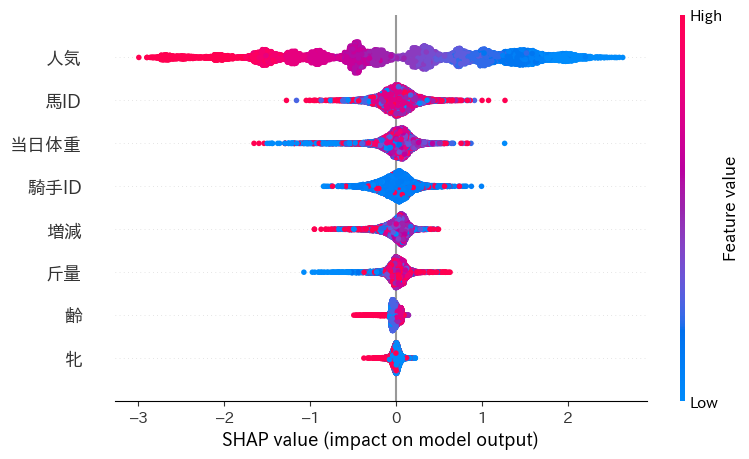

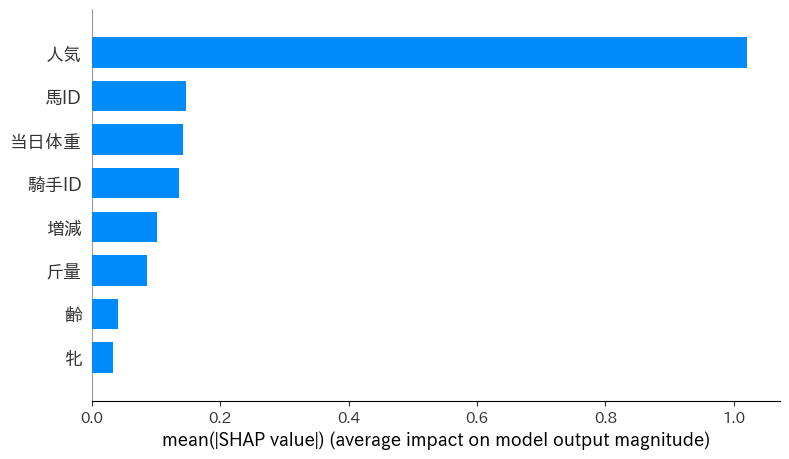

In [18]:
# SHAP値の計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP値の可視化
# 1. Summary Plot
shap.summary_plot(shap_values, X_test)

# 2. Feature Importance Bar Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")